<h1> GeoDirtyAnalysis v 0.0.1</h1>
Programa que realiza análises estatísticas e visualização para dados georreferenciados. Permite ao usuário obter *insigths* iniciais sobre alguma área de estudo
Por: Heitor Nóbrega Tico;

https://github.com/HeitorNT

<h1>CONCENTRADO DE BATEIA</h1>

#Importações, troca de diretório e carregamento de banco

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Troca diretório

In [0]:
%cd /content/gdrive/My Drive/prosp_geoq

/content/gdrive/My Drive/prosp_geoq


In [0]:
import perso
import pandas as pd
import matplotlib.pyplot as plt
import stat
import numpy as np
import altair as alt
!pip install geostatspy
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
!pip install pyproj
import pyproj
import scipy

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 10.1MB 2.8MB/s 


Carrega banco

In [0]:
conc_bat = pd.read_excel('Lavras do Sul.xlsx', sheet_name= 0)

#Análise exploratória

In [0]:
conc_bat

,OBJECTID,id_amostra,amostra,numero_campo,base_cartografica,id_classe_amostra,classe_amostra,tipo_amostra,material_coletado,fonte_amostra,situacao_amostra,area_drenagem,projeto,metodo,unidade,au,DATUM,POINT_X,POINT_Y
0,25681,274368,JBP389,EM0223,SH-22-Y-A-IV-4,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,"0,57",SIRGAS 2000,-53.722222,-30.958333
1,25690,277127,JBQ413,JZ0061,SH-22-Y-A-IV-2,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,6645,SIRGAS 2000,-53.528611,-30.561389
2,25788,277136,JBQ422,JZ0070,SH-22-Y-A-IV-2,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,Não detectado,SIRGAS 2000,-53.581667,-30.654167
3,25789,277142,JBQ428,JZ0076,SH-22-Y-A-IV-2,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,6735,SIRGAS 2000,-53.521111,-30.648056
4,25802,277167,JBQ454,JZ0102,SH-22-Y-A-IV-2,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,18685,SIRGAS 2000,-53.564444,-30.689722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,857601,272788,JBP355,ES0148,SH-22-Y-A-IV-3,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,"0,005",SIRGAS 2000,-53.785000,-30.992222
160,858323,277141,JBQ427,JZ0075,SH-22-Y-A-IV-2,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,"0,155",SIRGAS 2000,-53.533056,-30.652500
161,885392,274361,JBP382,EM0216,SH-22-Y-A-IV-4,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,4005,SIRGAS 2000,-53.698611,-30.899722
162,885410,272780,JBP347,EM0186,SH-22-Y-A-IV-4,2,Concentrado de bateia,Composto,Aluvião,Afloramento,Leito ativo abaixo do nível d'agua,Até 10 Km2,Ouro RS/SC,Espectroscopia de absorção atômica,ppm,"0,11",SIRGAS 2000,-53.680556,-30.925556


Sumário estatístico

In [0]:
conc_bat.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
OBJECTID,164,NaN,NaN,NaN,356330,318408,25681,27660.8,416661,638435,885504
id_amostra,164,NaN,NaN,NaN,275734,2319.52,272721,272796,277122,277163,279352
amostra,164,164,JBQ456,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numero_campo,164,164,EM0179,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
base_cartografica,164,3,SH-22-Y-A-IV-4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id_classe_amostra,164,NaN,NaN,NaN,2,0,2,2,2,2,2
classe_amostra,164,1,Concentrado de bateia,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_amostra,164,1,Composto,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
material_coletado,164,1,Aluvião,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fonte_amostra,164,1,Afloramento,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Verificação dos tipos de variáveis

In [0]:
conc_bat.dtypes

OBJECTID               int64
id_amostra             int64
amostra               object
numero_campo          object
base_cartografica     object
id_classe_amostra      int64
classe_amostra        object
tipo_amostra          object
material_coletado     object
fonte_amostra         object
situacao_amostra      object
area_drenagem         object
projeto               object
metodo                object
unidade               object
au                    object
DATUM                 object
POINT_X              float64
POINT_Y              float64
dtype: object

##Ajustando o banco
Com base no sumário estatístico é possível perceber que as únicas colunas relevantes são: amostra, au, POINT_X, POINT_Y. Além disso a verificação dos tipos de dados demonstrou que a conversão de au para float é necessária.

Seleciona colunas úteis:

In [0]:
col_uteis = ['amostra', 'au', 'POINT_X', 'POINT_Y']

In [0]:
conc_bat = conc_bat.loc[:,col_uteis]

Remove linhas onde não há medidas de ouro

In [0]:
conc_bat_wau = conc_bat.loc[(conc_bat.au != 'Não detectado')]

Muda ponto por vírgula na coluna au

In [0]:
bd = conc_bat_wau.replace(',', '.', regex=True)

Converte o tipo de dado

In [0]:
bd.au = bd.au.astype(float)

Converte tipo de coordenadas

In [0]:
source = pyproj.Proj(proj='latlong', datum='WGS84')

In [0]:
target = pyproj.Proj(proj='utm', zone=22, datum='WGS84')

In [0]:
point_x = bd.POINT_X.to_list()
point_y = bd.POINT_Y.to_list()

In [0]:
x, y = pyproj.transform(source, target, point_x, point_y)

In [0]:
bd['POINT_X'] = x
bd['POINT_Y'] = y 

##Estatística univariada

Novo sumário estatístico

In [0]:
sumario = perso.sumaEst(bd)
sumario.T

,contagem,média,variância,desvio padrão,coeficiente de variação,mínimo,q1,q2,q3,máximo,skewness,curtose,início ouliers superiores,n° outliers superiores,início outliers inferiores,n° outliers inferiores,início extremos superiores,n° extremos superiores,início extremos inferiores,n° extremos inferiores
au,145.000,1436.165,15312156.927,3913.075,2.725,0.002,0.070,0.495,35.260,23385.000,3.796,15.965,88.045,2.000,-52.715,0.000,140.830,32.000,-105.500,0.000
POINT_X,145.000,248972.110,102272726.295,10112.998,0.041,213527.380,245172.277,251561.329,256668.125,260707.539,-1.763,3.589,273911.897,0.000,227928.506,7.000,291155.669,0.000,210684.734,0.000
POINT_Y,145.000,-3410149.719,244832897.486,15647.137,-0.005,-3432772.699,-3424578.969,-3405982.513,-3397372.594,-3377078.340,0.102,-1.334,-3356563.031,0.000,-3465388.531,0.000,-3315753.468,0.000,-3506198.094,0.000


Histograma

In [0]:
alt.Chart(bd).mark_bar().encode(
  x=alt.X('au', bin=True),
  y='count()',)

alt.Chart(...)

Forte assimetria positiva é verificada para o ouro, esse tipo de distribuição é típico para metais. Porém a heterogeneidade verificada através da confontração entre média e desvio padrão não oferece interpretações coerentes para essa população. Uma nova população livre de extremos será gerada.

Sumário estatístico livre de extremos
(Os novos valores extremos não são representativos)

In [0]:
bd_sext = bd.loc[(bd['au'] < sumario.loc['início extremos superiores', 'au']) &
                 (bd['au'] > sumario.loc['início extremos inferiores', 'au'])]
sumario_sext = perso.sumaEst(bd_sext)
sumario_sext.drop(['POINT_X', 'POINT_Y'], axis=1).T

,contagem,média,variância,desvio padrão,coeficiente de variação,mínimo,q1,q2,q3,máximo,skewness,curtose,início ouliers superiores,n° outliers superiores,início outliers inferiores,n° outliers inferiores,início extremos superiores,n° extremos superiores,início extremos inferiores,n° extremos inferiores
au,113.000,4.716,249.486,15.795,3.349,0.002,0.035,0.145,0.990,102.460,4.883,26.031,2.422,2.000,-1.397,0.000,3.855,18.000,-2.830,0.000


Histograma livre de extremos

In [0]:
bd_sext = bd.loc[(bd['au'] < sumario.loc['início extremos superiores', 'au']) &
                 (bd['au'] > sumario.loc['início extremos inferiores', 'au'])]
alt.Chart(bd_sext).mark_bar().encode(x=alt.X('au', bin=True),
  y='count()',)

alt.Chart(...)

Essa nova população exibe comportamento comportamento estatístico coerente. Esses valores extremos representam uma anomalia no banco de dados, ou seja, provavelmente evidênciam uma área enriquecida em Au. Apesar de claramente caracterizar outra população, esses valores anômalos serão mantidos no atual banco de dados.

#Localização das amostras

Localização de todas as amostras

In [0]:
xmin = 210000.000 ; xmax = 265000.000
ymin = -3440000.000 ; ymax = -3370000.000
aumin = 0.0015 ; aumax = 23386.0000
cmap = plt.cm.plasma

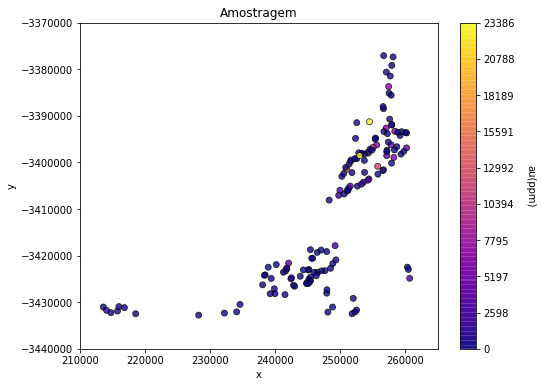

In [0]:
GSLIB.locmap(bd, 'POINT_X', 'POINT_Y', 'au', xmin, xmax, ymin, ymax, aumin,
             aumax, 'Amostragem', 'x', 'y', 'au(ppm)', cmap, 'loc_au')

Localização das amostras com valores extremos

In [0]:
ext = bd.loc[(bd['au'] > sumario.loc['início extremos superiores', 'au'])]
#perso.sumaEst(ext).T

In [0]:
xmin = 210000.000 ; xmax = 265000.000
ymin = -3440000.000 ; ymax = -3370000.000
aumin = 0.0015 ; aumax = 23386.0000
cmap = plt.cm.plasma

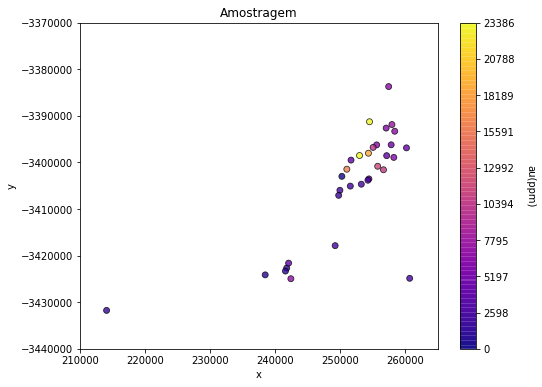

In [0]:
GSLIB.locmap(ext, 'POINT_X', 'POINT_Y', 'au', xmin, xmax, ymin, ymax, aumin,
             aumax, 'Amostragem', 'x', 'y', 'au(ppm)', cmap, 'loc_extau')

É nítida a existência de um agrupamento preferencial na região mais rica (região de teores anômalos),
qualquer medida estatística que deconsidere essa circunstância é enviesada.
Para contornar essa situação e proceder com as análises, será realizado o desagrupamento espacial das amostras.

#Desagrupamento por células móveis

Espaçamento médio

In [0]:
em = int(np.sqrt(((xmax - xmin)*(ymax - ymin)))/len(bd.au))
em

427

In [0]:
int((xmax - xmin)*(ymax - ymin))

3850000000

In [0]:
wts, cell_sizes, dmeans = geostats.declus(bd, 'POINT_X', 'POINT_Y', 'au', 1, 10,50, 400,1700)

There are 145 data with:
   mean of      1436.1648551724136 
   min and max  0.002 and 23385.0
   standard dev 3899.55841662571 


Validando melhor tamanho de célula

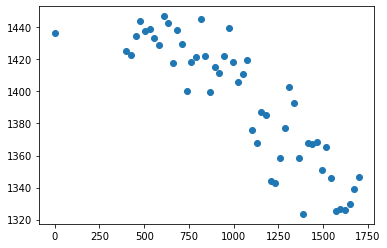

In [0]:
plt.scatter(cell_sizes, dmeans)

In [0]:
bd['wts'] = wts

visualizando pesos

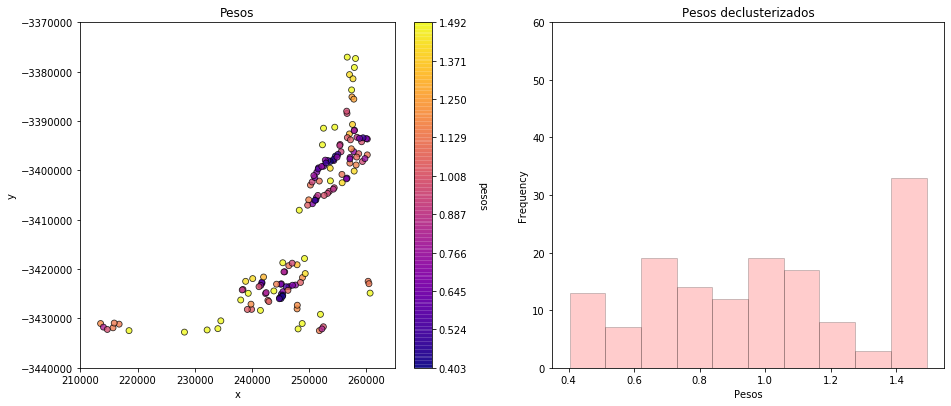

In [0]:
plt.subplot(121)
GSLIB.locmap_st(bd, 'POINT_X', 'POINT_Y', 'wts', xmin, xmax, ymin, ymax, min(wts),
             max(wts), 'Pesos', 'x', 'y', 'pesos', cmap)

plt.subplot(122)
GSLIB.hist_st(bd['wts'], min(wts), max(wts), bins=10, xlabel='Pesos', title='Pesos declusterizados', log=False, weights=None, cumul=False)
plt.ylim(0.0, 60)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Em análise ocular o desagrupamento se mostrou efetivo pois pesos maiores foram dados as amostras mais esparsas enquanto que as amostras agrupadas receberam pesos menores 

Comparação entre dataset agrupado e desagrupado

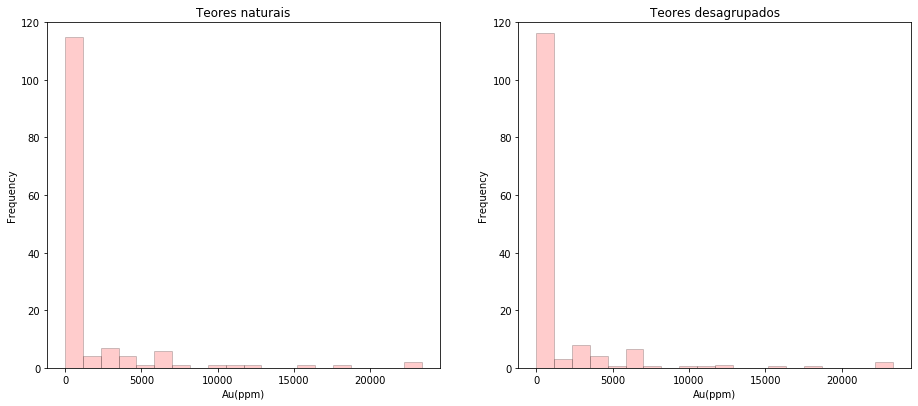

In [0]:
plt.subplot(121)
GSLIB.hist_st(bd['au'], min(bd['au']), max(bd['au']), log=False, cumul=False,
weights = None, xlabel='Au(ppm)', title='Teores naturais', bins=20); plt.ylim(0.0,120)
plt.subplot(122)
GSLIB.hist_st(bd['au'], min(bd['au']), max(bd['au']), log=False, cumul=False, bins=20, weights=wts, xlabel='Au(ppm)', title='Teores desagrupados');plt.ylim(0.0,120)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

O desagrupamento produziu uma singela diferença, pode ser observada nas amostras de menor frequência e de maior teor.

sumário estatístico agrupado(au) e desagrupado(auw)

In [0]:
bd['auw'] = bd['au']*bd['wts']

In [0]:
s = perso.sumaEst(bd)
s.drop(['wts', 'POINT_X', 'POINT_Y'], axis=1).T

,contagem,média,variância,desvio padrão,coeficiente de variação,mínimo,q1,q2,q3,máximo,skewness,curtose,início ouliers superiores,n° outliers superiores,início outliers inferiores,n° outliers inferiores,início extremos superiores,n° extremos superiores,início extremos inferiores,n° extremos inferiores
au,145.000,1436.165,15312156.927,3913.075,2.725,0.002,0.070,0.495,35.260,23385.000,3.796,15.965,88.045,2.000,-52.715,0.000,140.830,32.000,-105.500,0.000
auw,145.000,1323.575,14724328.022,3837.229,2.899,0.002,0.051,0.383,24.087,34459.370,5.389,39.509,60.142,1.000,-36.003,0.000,96.196,33.000,-72.058,0.000


O desagrupamento produziu maior dispersão na distribuição do que os dados agrupados. Isso acontece poque existe uma mistura populacional (32 teores anômalos) que interferem na homogenidade dos dados.

#Distribuição espacial dos teores de Au

Converte dimensão dos dados

In [0]:
x = np.array(bd.POINT_X.values)
y = np.array(bd.POINT_Y.values)
z = np.array(bd.au.values)
resol = float(em)

Cria grid

In [0]:
xinum = (max(x) - min(x)) / resol
yinum = (max(y) - min(y)) / resol
xi = np.linspace(min(x), max(x), xinum)
yi = np.linspace(min(y), max(y), yinum)
xi, yi = np.meshgrid(xi, yi)
zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')
#Zi =  np.ma.masked_array(zi, zi < 1)

Mapa de distribuição espacial

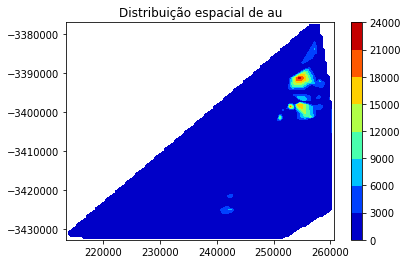

In [0]:
cmap = plt.get_cmap('jet')
c = plt.contourf(xi, yi, zi, cmap=cmap)
plt.colorbar(c)
plt.title('Distribuição espacial de au')
plt.show()

O mapa acima confirma o que já havia sido visualisado nos mapas de distribuição das amostras. A população de valores extremos de Au (anômalos), se concentram na região nordeste  da área de estudo. Recomenda-se que posteriores campanhas, em escala de detalhe, se concentrem nessa região. 